# Project McNulty: Predicting Illegal Drugs Consumption

Elvis Davalillo - info@elvisdavalillo.com

Part 1/2 - Database management, cleaning and  exploratory data analysis for survey data

Process:

    1.Data Gathering
    2.Data Cleaning
    3.Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import pyreadstat
import psycopg2 as pg
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#!pip install pyreadstat

In [ ]:
#drugs2_df = pd.read_csv('NSDUH_2016_Tab.tsv', sep='\t')

In [ ]:
#drugs2_df.PIPE30DY.unique()

In [ ]:
#df = pd.read_csv('NSDUH_2017_Tab.tsv', sep='\t')

In [ ]:
#df.head()

## Survey Responses Data Gathering

In [2]:
# Let's download the data for the most relevant/complete 25 features
few_columns = ['QUESTID2','FILEDATE','CATAG3','SERVICE','EDUHIGHCAT','IRWRKSTAT','ANYHLTI2',
               'INCOME','COUTYP4','IRMARIT','CIGYR','ALCYR','MRJYR','ILLEMYR','PNRANYYR',
               'OXYCNANYYR','TRQANYYR','CIGALCMO','HVYDRKMON','IRSEX','NEWRACE2','IRPRVHLT','BOOKED',
               'DSTNRV30','DSTRST30']

In [3]:
df, meta = pyreadstat.read_sav('NSDUH_2017.sav',usecols=few_columns, apply_value_formats=True, formats_as_category=True)

In [4]:
print(meta.value_labels)

{'labels0': {1.0: '1 - Yes', 2.0: '2 - No'}, 'labels1': {1.0: '1 - Definitely Yes', 2.0: '2 - Probably Yes', 3.0: '3 - Probably Not', 4.0: '4 - Definitely Not', 94.0: '94 - DON T KNOW', 97.0: '97 - REFUSED', 99.0: '99 - LEGITIMATE SKIP'}, 'labels2': {1.0: '1 - Definitely Yes', 2.0: '2 - Probably Yes', 3.0: '3 - Probably Not', 4.0: '4 - Definitely Not', 85.0: '85 - BAD DATA Logically assigned', 94.0: '94 - DON T KNOW', 97.0: '97 - REFUSED', 99.0: '99 - LEGITIMATE SKIP'}, 'labels3': {985.0: '985 - BAD DATA Logically assigned', 991.0: '991 - NEVER USED CIGARETTES', 994.0: '994 - DON T KNOW', 997.0: '997 - REFUSED'}, 'labels4': {9985.0: '9985 - BAD DATA Logically assigned', 9989.0: '9989 - LEGITIMATE SKIP Logically assigned', 9991.0: '9991 - NEVER USED CIGARETTES', 9994.0: '9994 - DON T KNOW', 9997.0: '9997 - REFUSED', 9998.0: '9998 - BLANK', 9999.0: '9999 - LEGITIMATE SKIP'}, 'labels5': {1.0: '1 - January', 2.0: '2 - February', 3.0: '3 - March', 4.0: '4 - April', 5.0: '5 - May', 6.0: '6 -

In [5]:
df.to_pickle('raw_survey.pkl')

In [6]:
df = pd.read_pickle('raw_survey.pkl')

In [7]:
#let's clean and group the survey responses for easier analysis
labels = pd.read_csv('labels.csv')

In [8]:
labels = labels.set_index('ID')['LABELS'].to_dict()

In [9]:
df = df.replace(labels)

In [10]:
df["BOOKED"].unique()

array(['0', '1'], dtype=object)

In [ ]:
df.head()

In [ ]:
non_health_columns = ['QUESTID2','FILEDATE','CATAG3','SERVICE','EDUHIGHCAT','IRWRKSTAT','ANYHLTI2',
               'INCOME','COUTYP4','IRMARIT','CIGYR','ALCYR','MRJYR','ILLEMYR','PNRANYYR',
               'OXYCNANYYR','TRQANYYR','CIGALCMO','HVYDRKMON','IRSEX','NEWRACE2','IRPRVHLT']

In [ ]:
# I am separating the health columns to create a separate SQL table to practice join
health_columns = ['QUESTID2','BOOKED','DSTNRV30','DSTRST30']

In [ ]:
df.to_csv('raw_survey.csv')

In [ ]:
df[health_columns].to_csv('health.csv')

In [ ]:
#let's retrieve the database we just created

### SQL Data Interaction

In [ ]:
connection_args = {
    'host': '####',  # Removed for privacy reasons
    'user': '####',    # removed for privacy reasons
    'dbname': 'survey_data',    # DB that we are connecting to
    'port': ####             # removed for privacy reasons
}

connection = pg.connect(**connection_args)

In [ ]:
cursor = connection.cursor()
cursor.execute('SELECT * FROM survey_full LIMIT 5')
list(cursor.fetchall());

Let's start analyzing our target ILLEMYR which represents illicit drug consumption, excluding Marijuana and including: Cocaine, Hallucinogens, Heroine, Inhalants, Methamphetamine, and Illegal Psycotherapeutics

In [ ]:
#Let's analyze by age group
pd.read_sql(
'SELECT CATAG3,COUNT (*) FROM survey_full WHERE  ILLEMYR =1 GROUP BY CATAG3',
connection
)

In [ ]:
pd.read_sql(
'SELECT CATAG3,COUNT (*) FROM survey_full WHERE  ILLEMYR =0 GROUP BY CATAG3',
connection
)

In [ ]:
#Let's analyze by gender
pd.read_sql(
'SELECT IRSEX,COUNT (*) FROM survey_full WHERE  ILLEMYR =1 GROUP BY IRSEX',
connection
)

In [ ]:
pd.read_sql(
'SELECT IRSEX,COUNT (*) FROM survey_full WHERE  ILLEMYR =0 GROUP BY IRSEX',
connection
)

In [ ]:
#Let's analyze by military service
pd.read_sql(
'SELECT ILLEMYR,COUNT (*) FROM survey_full WHERE  SERVICE =1 GROUP BY ILLEMYR',
connection
)

In [ ]:
#Let's analyze by gender
pd.read_sql(
'SELECT ILLEMYR,COUNT (*) FROM survey_full WHERE  SERVICE =0 GROUP BY ILLEMYR',
connection
)

In [ ]:
#58% of the surveyed population is nonhisp white
pd.read_sql(
'SELECT NEWRACE2,COUNT(NEWRACE2)*100.0 / (SELECT COUNT(*) FROM survey_full)\
 as Percentage FROM survey_full GROUP BY NEWRACE2',
connection
)

In [ ]:
# with only 58% of the total survey population NonHisp White contributes to 63% of illegal drug consumption
pd.read_sql(
'SELECT NEWRACE2,COUNT(NEWRACE2)*100.0 / (SELECT COUNT(*) FROM survey_full WHERE ILLEMYR =1) \
as Percentage FROM survey_full WHERE ILLEMYR =1 GROUP BY NEWRACE2',
connection
)

In [ ]:
#
pd.read_sql(
'SELECT * FROM health LIMIT 20;',
connection
)

In [ ]:
# Now we have done some EDA in SQL let's create a df joining the different SQL tables for easier readability 

In [ ]:
df = pd.read_sql(
'SELECT survey_full.*, health.booked,health.dstnrv30,health.dstrst30 FROM\
     survey_full LEFT JOIN health\
    ON survey_full.QUESTID2 = health.QUESTID2',     
connection
)

In [ ]:
#Let's drop some columns that we won't be using
df = df.drop(['id','filedate'], axis=1)

In [ ]:
df.columns

In [11]:
new_columns = ['ID','CIGS','ALCOHOL','MARIJUANA','PAIN_REL','OXYCONTIN','TRANQUIL','ILLICIT','CIG_ALC',
               'HEAVY_ALC','ARMY','GENDER','MARITAL','AGE','RACE','EDUCATION','EMPLOYMENT','PRIV_HEALTH',
               'HEALTH','INCOME','COUNTY','ARRESTED','NERVOUS','RESTLESS']

In [ ]:
df.columns = new_columns

In [ ]:
df.dtypes

In [ ]:
# let's convert nervous and restless to integers
df['NERVOUS'] = df['NERVOUS'].astype('float')

In [ ]:
df['RESTLESS'] = df['RESTLESS'].astype('float')

In [ ]:
df['PRIV_HEALTH'] = df['PRIV_HEALTH'].astype('int')

In [ ]:
df.to_pickle('df.pkl')

In [3]:
df = pd.read_pickle('df.pkl')

## Exploratory Data Analysis (EDA)

Target Feature: ILLICIT
Description: Whether the person has done illicit drugs in the last 12 months. Key: 0 = did not do illegal drugs, 1 = did illegal drugs This is the variable we want our machine learning model to predict based off all the others.

0    50030
1     6246
Name: ILLICIT, dtype: int64


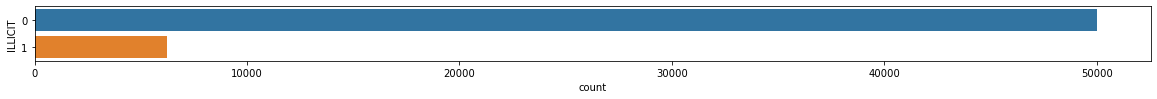

In [25]:
# How many people have done illicit drugs?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='ILLICIT', data=df);
print(df.ILLICIT.value_counts())

In [4]:
# let's start analyzing our target variable which is the consumption of illicit drugs in the last 12 months
df.groupby('ILLICIT').mean()

,CIGS,ALCOHOL,MARIJUANA,PAIN_REL,OXYCONTIN,TRANQUIL,HEAVY_ALC,ARMY,PRIV_HEALTH,HEALTH,ARRESTED,NERVOUS,RESTLESS
ILLICIT,,,,,,,,,,,,,
0,0.190386,0.578513,0.140036,0.258085,0.020468,0.085609,0.046392,0.047032,0.625165,0.903818,0.120867,0.186748,0.155052
1,0.538264,0.843100,0.622959,0.640410,0.127762,0.383926,0.194685,0.032821,0.579091,0.869837,0.301793,0.308838,0.291106


In [5]:
#we can see people that smokes cigs and do alcohol are more likely to do illicit drugs
df.groupby('CIGS').mean()

,ALCOHOL,MARIJUANA,PAIN_REL,OXYCONTIN,TRANQUIL,ILLICIT,HEAVY_ALC,ARMY,PRIV_HEALTH,HEALTH,ARRESTED,NERVOUS,RESTLESS
CIGS,,,,,,,,,,,,,
0,0.543686,0.123603,0.260642,0.023093,0.091406,0.066468,0.034732,0.042753,0.652446,0.917998,0.091567,0.174998,0.141712
1,0.824009,0.429425,0.434779,0.063630,0.210677,0.260883,0.157523,0.054551,0.510980,0.839606,0.307209,0.285481,0.265908


In [6]:
df.groupby('ALCOHOL').mean()

,CIGS,MARIJUANA,PAIN_REL,OXYCONTIN,TRANQUIL,ILLICIT,HEAVY_ALC,ARMY,PRIV_HEALTH,HEALTH,ARRESTED,NERVOUS,RESTLESS
ALCOHOL,,,,,,,,,,,,,
0,0.102778,0.051570,0.220102,0.019169,0.066207,0.044410,0.000000,0.031993,0.535052,0.906920,0.085104,0.124303,0.102608
1,0.310415,0.285276,0.352393,0.040896,0.152591,0.153936,0.103394,0.054138,0.674881,0.895612,0.176971,0.249320,0.213723


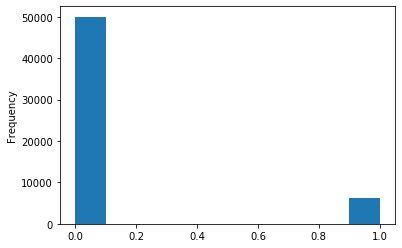

In [17]:
df.ILLICIT.plot.hist()

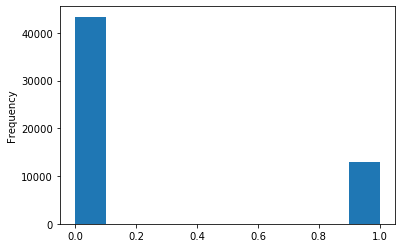

In [16]:
df.CIGS.plot.hist()

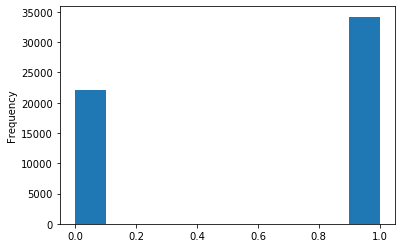

In [18]:
df.ALCOHOL.plot.hist()

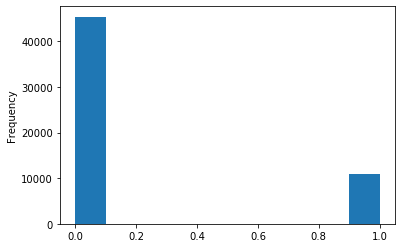

In [20]:
df.MARIJUANA.plot.hist()

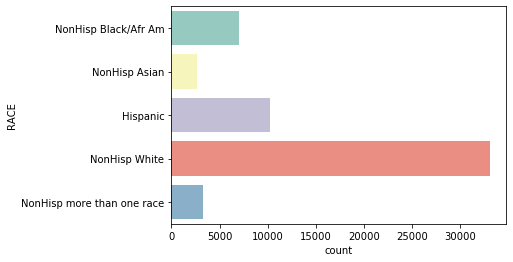

In [8]:
# Frequency Distribution
#sns.countplot(data = df, x = 'RACE')
#plt.xticks(rotation=45)

sns.countplot(y="RACE", data=df,palette="Set3")

Text(0, 0.5, 'Frequency')

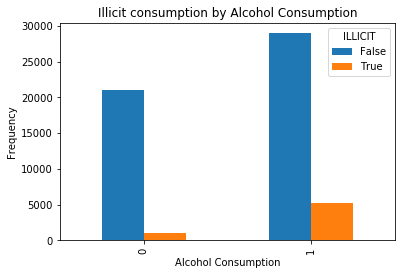

In [9]:
# barplot of pain reliever grouped by illicit(True or False)
pd.crosstab(df.ALCOHOL, df.ILLICIT.astype(bool)).plot(kind='bar')
plt.title('Illicit consumption by Alcohol Consumption')
plt.xlabel('Alcohol Consumption')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

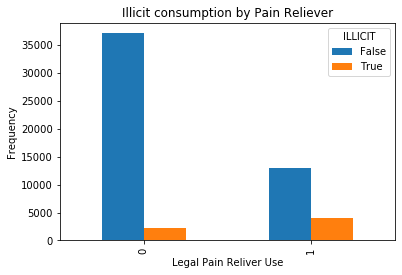

In [26]:
# barplot of pain reliever grouped by illicit(True or False)
pd.crosstab(df.PAIN_REL, df.ILLICIT.astype(bool)).plot(kind='bar')
plt.title('Illicit consumption by Pain Reliever')
plt.xlabel('Legal Pain Reliver Use')
plt.ylabel('Frequency')

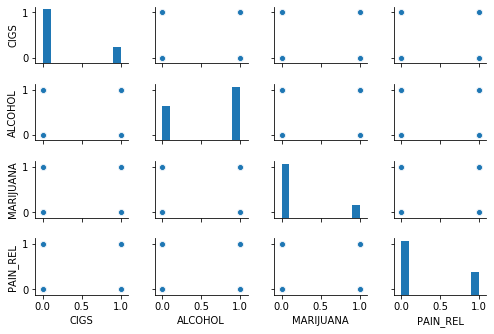

In [12]:
sns.pairplot(df[['CIGS','ALCOHOL','MARIJUANA','PAIN_REL']], height=1.2, aspect=1.5);

In [29]:
df.head()

,ID,CIGS,ALCOHOL,MARIJUANA,PAIN_REL,OXYCONTIN,TRANQUIL,ILLICIT,CIG_ALC,HEAVY_ALC,...,RACE,EDUCATION,EMPLOYMENT,PRIV_HEALTH,HEALTH,INCOME,COUNTY,ARRESTED,NERVOUS,RESTLESS
0,13435143,1,1,1,0,0,0,0,Past Mon Use of Cig & Alc,0,...,NonHisp Black/Afr Am,College graduate,Other,0,1,"$20,000 - $49,999",Large Metro,0,0.00,0.00
1,81345143,1,1,0,0,0,0,0,Past Mon Use of Cig & Alc,0,...,NonHisp Asian,Some coll/Assoc Dg,Employed full time,1,1,"$75,000 or More",Large Metro,0,0.50,0.75
2,53955143,0,1,0,0,0,0,0,Past Mon Use of Alc & No Cig,0,...,Hispanic,College graduate,Employed full time,0,1,"$75,000 or More",Small Metro,0,0.00,0.50
3,51775143,0,0,0,0,0,0,0,No Past Mon Use of Cig/Alc,0,...,NonHisp White,High school grad,Other,0,1,"$20,000 - $49,999",Large Metro,0,0.25,0.00
4,47796143,0,1,0,0,0,0,0,No Past Mon Use of Cig/Alc,0,...,NonHisp White,Less high school,Other,1,1,"Less than $20,000",Nonmetro,0,0.00,0.00


In [12]:
#Verify there are no null values
df.isnull().sum()

QUESTID2      0
FILEDATE      0
CIGYR         0
ALCYR         0
MRJYR         0
PNRANYYR      0
OXYCNANYYR    0
TRQANYYR      0
ILLEMYR       0
CIGALCMO      0
HVYDRKMON     0
BOOKED        0
DSTNRV30      0
DSTRST30      0
SERVICE       0
IRSEX         0
IRMARIT       0
CATAG3        0
NEWRACE2      0
EDUHIGHCAT    0
IRWRKSTAT     0
IRPRVHLT      0
ANYHLTI2      0
INCOME        0
COUTYP4       0
dtype: int64